# Load necessary packages
#### Python 3.8.10

In [1]:
import os

from cmcrameri import cm as cm_ref
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from sklearn.covariance import EllipticEnvelope
from sklearn.inspection import DecisionBoundaryDisplay

import sigclust as sigclust

# Define the used functions

In [2]:
def p_value_sf(p_value):
    # Determine the significant figures: https://evidence.nejm.org/about/editorial-policies
    if p_value > 0.01:
        return f'p = {p_value:.2f}'
    elif ((p_value <= 0.01) and (p_value >= 0.001)):
        return f'p = {p_value:.3f}'
    else:
        return 'p < 0.001'


# Define used paths

In [3]:
DATA_PATH = os.path.join('data_anonymized','MR-Sim','volunteer')

# Define the quantitative ranges

In [4]:
CMAPS = {
    'T1': cm_ref.lipari,
    'T2': cm_ref.navia,
    'PD': cm_ref.glasgow
}

UNIT_TYPES = {
    'T1': 'ms',
    'T2': 'ms',
    'PD': 'pu'
}

MIN_RANGE = {
    'T1': 250,
    'T2': 10,
    'PD': 0
}
MAX_RANGE = {
    'T1': 4300,
    'T2': 2000,
    'PD': 160
}
MIN_RANGE_CLINICAL = {
    'T1': 250,
    'T2': 30,
    'PD': 20
}
MAX_RANGE_CLINICAL = {
    'T1': 2000,
    'T2': 200,
    'PD': 160
}

# Load the healthy volunteers

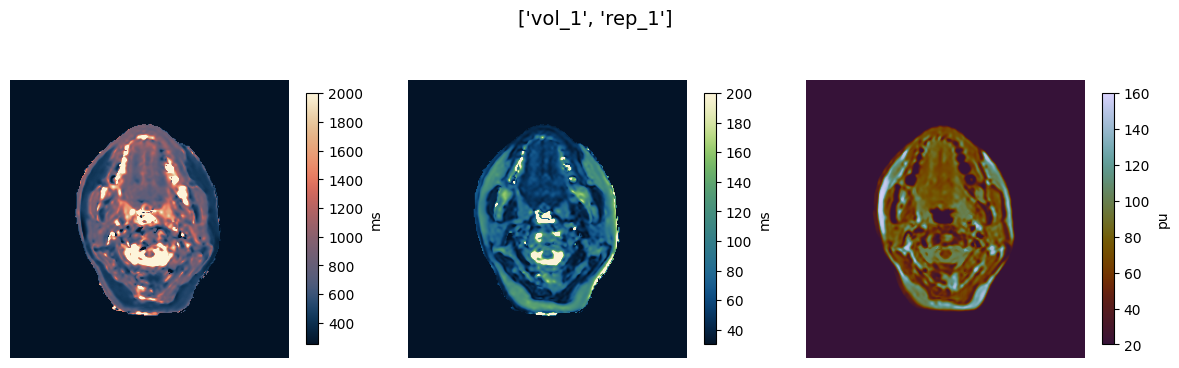

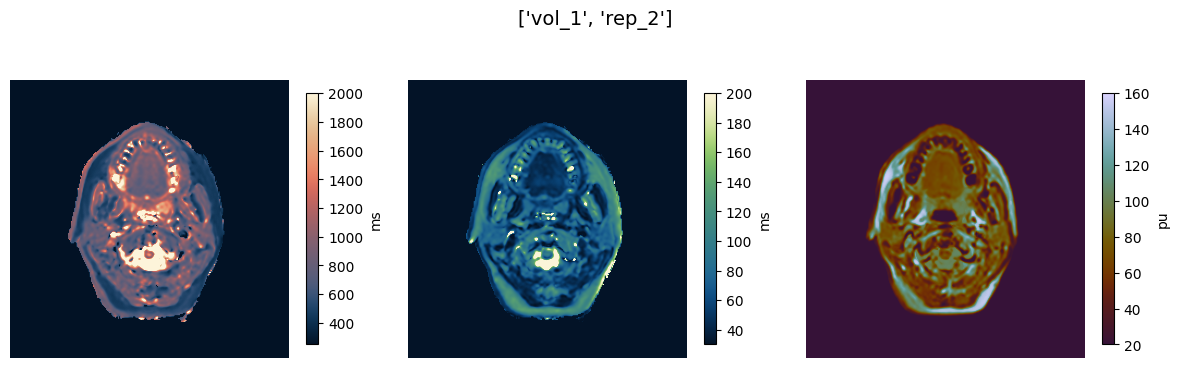

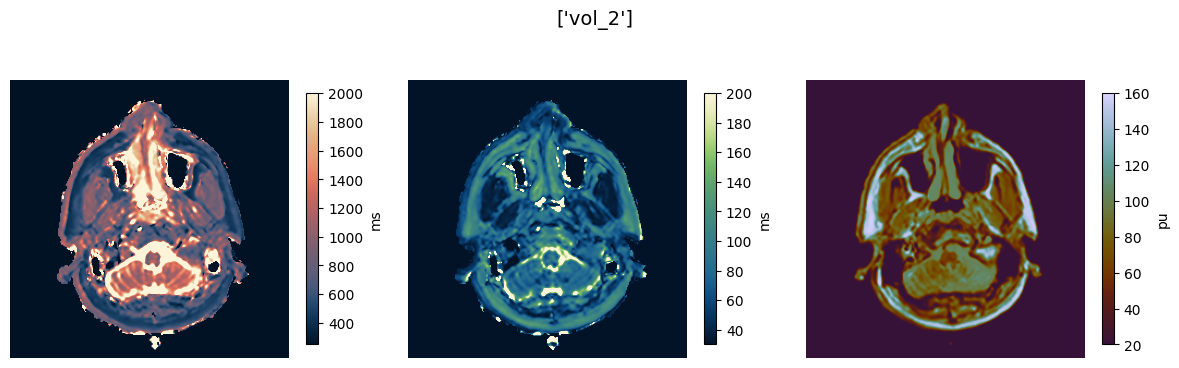

In [5]:
im_types = ['T1','T2','PD']
all_sp = {
    1: os.path.join('vol_1','rep_1'),
    2: os.path.join('vol_1','rep_2'),
    3: 'vol_2'
}


all_image_data = {}
filtered_all_image_data = {}

for sp in all_sp.keys():
    all_image_data[sp] = {}
    filtered_all_image_data[sp] = {}
    all_image_files = {
        im_type: os.path.join(DATA_PATH, all_sp[sp], f'SYMAPS_{im_type}.nii.gz')
        for im_type in im_types
    }

    # Combine all the imaging data into a single array
    for im_type in im_types:
        all_image_data[sp][im_type] = {}
        filtered_all_image_data[sp][im_type] = {}
        # Read the image file
        temp_img = nib.load(all_image_files[im_type])
        temp_linear = temp_img.get_fdata()
        scl_slope = temp_img.header['scl_slope']
        if np.isnan(scl_slope):
            scl_slope = 1
        scl_inter = temp_img.header['scl_inter']
        if np.isnan(scl_inter):
            scl_inter = 0
        scaled_data = scl_slope*temp_linear + scl_inter
        scaled_data = np.transpose(scaled_data, (2,1,0))
        # Save the data
        all_image_data[sp][im_type]['all'] = scaled_data
        filtered_all_image_data[sp][im_type]['all'] = scaled_data[~np.isnan(scaled_data)]

    fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
    for i,im_type in enumerate(['T1','T2','PD']):
        sample_image_mat = all_image_data[sp][im_type]['all']
        slice_loc = int(sample_image_mat.shape[0] / 2)
        sample_image_mat = sample_image_mat[slice_loc,:,:]
        temp_im = axes[i].imshow(sample_image_mat, vmin=MIN_RANGE_CLINICAL[im_type], vmax=MAX_RANGE_CLINICAL[im_type], cmap=CMAPS[im_type])
        axes[i].axis('off')
        cbar = plt.colorbar(temp_im, shrink=0.75, ax=axes[i])
        cbar.ax.tick_params(labelsize=10)
        cbar.set_label(label='pu' if im_type=='PD' else 'ms', size=10)
    plt.suptitle(all_sp[sp].split(os.sep), fontsize=14)
    plt.tight_layout()
    plt.show()


# Visualize the RTSTRUCTs and extract the values

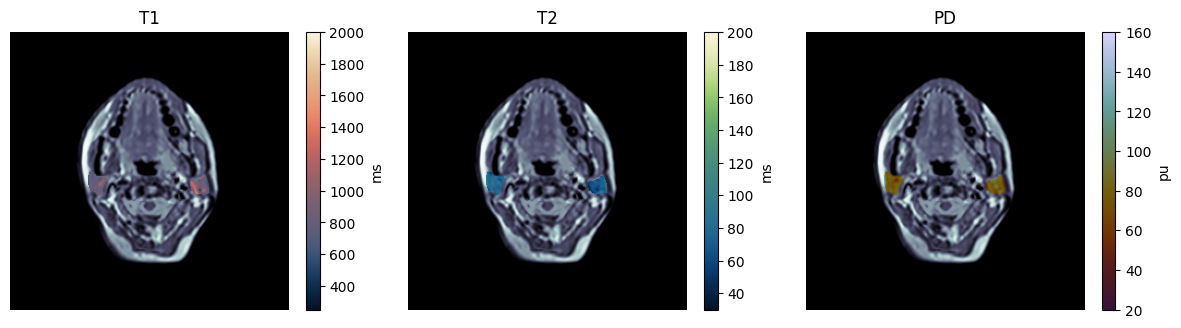

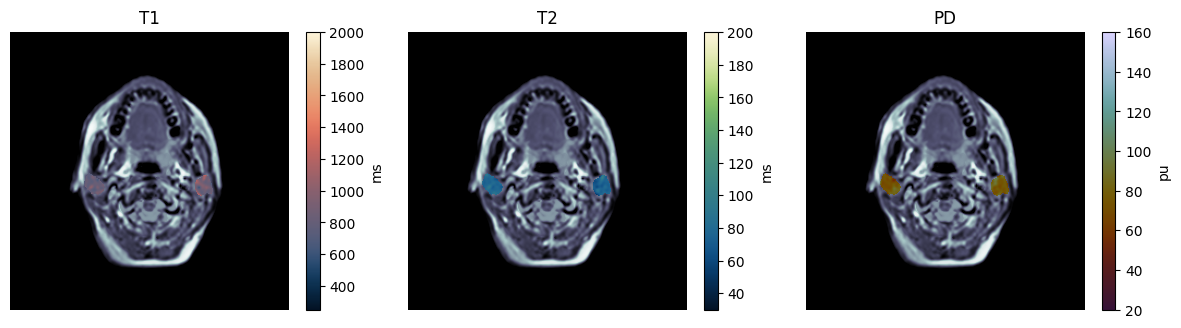

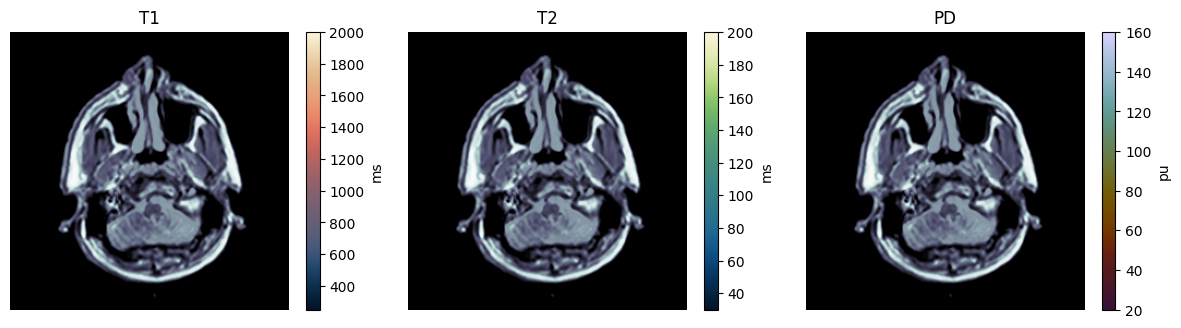

In [6]:
struct_types = [
    'Parotid_L',
    'Parotid_R',
    'Glnd_Submand_L',
    'Glnd_Submand_R'
]
all_struct_data = {}
SHOW_PLOT = True


for sp in list(all_sp.keys())[:]:
    all_struct_data[sp] = {}

    if SHOW_PLOT:
        fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

    slice_loc = 25
    for s,struct_type in enumerate(struct_types):
        all_struct_data[sp][struct_type] = {}
        struct_mask = nib.load(os.path.join(DATA_PATH, all_sp[sp], f'{struct_type}.nii'))
        struct_mask = np.transpose(struct_mask.get_fdata(), (2,1,0))

        for i,im_type in enumerate(['T1','T2','PD']):
            # Load the SyMap
            current_image_data = all_image_data[sp][im_type]['all']

            # Save the extracted segment with spatial information
            saved_image_mat = np.empty(current_image_data.shape, dtype=np.float64)
            saved_image_mat[:] = np.nan
            saved_nonzero_struct_mask = np.where(struct_mask == 1)
            saved_image_mat[saved_nonzero_struct_mask] = current_image_data[saved_nonzero_struct_mask]
            temp_im_data = saved_image_mat.copy()
            all_image_data[sp][im_type][struct_type] = temp_im_data
            filtered_all_image_data[sp][im_type][struct_type] = temp_im_data

            # Extract the values
            temp_im_data = temp_im_data[~np.isnan(temp_im_data)]
            all_struct_data[sp][struct_type][im_type] = {
                'mean': np.nanmean(temp_im_data),
                'median': np.nanmedian(temp_im_data),
                'std': np.nanstd(temp_im_data),
                'cov': 100 * np.nanstd(temp_im_data) / np.nanmean(temp_im_data)
            }

            if SHOW_PLOT:
                # Show where the segment is
                temp_image_mat = current_image_data[slice_loc,:,:].copy()
                temp_image_mat[struct_mask[slice_loc,:,:] != 1] = np.nan
                if s == 0:
                    axes[i].imshow(all_image_data[sp]['PD']['all'][slice_loc,:,:], vmin=MIN_RANGE_CLINICAL['PD'], vmax=MAX_RANGE_CLINICAL['PD'], cmap=plt.cm.bone, alpha=1)
                temp_im = axes[i].imshow(temp_image_mat, vmin=MIN_RANGE_CLINICAL[im_type], vmax=MAX_RANGE_CLINICAL[im_type], cmap=CMAPS[im_type], alpha=1)
                if s == 0:
                    axes[i].axis('off')
                    axes[i].set_title(im_type, fontsize=12)
                    cbar = plt.colorbar(temp_im, shrink=0.75, ax=axes[i])
                    cbar.ax.tick_params(labelsize=10)
                    cbar.set_label(label=UNIT_TYPES[im_type], size=10)

    if SHOW_PLOT:
        # plt.suptitle(all_sp[sp], fontsize=14)
        plt.tight_layout()
        plt.show()


# Cluster analysis

C:\Users\lbmccullum\AppData\Local\Temp\ipykernel_30840\713989332.py:40: RuntimeWarning: invalid value encountered in cast
  temp_points = np.vstack((filtered_x, filtered_y)).T.astype(np.int16)
C:\Users\lbmccullum\AppData\Local\Temp\ipykernel_30840\713989332.py:40: RuntimeWarning: invalid value encountered in cast
  temp_points = np.vstack((filtered_x, filtered_y)).T.astype(np.int16)
C:\Users\lbmccullum\AppData\Local\Temp\ipykernel_30840\713989332.py:40: RuntimeWarning: invalid value encountered in cast
  temp_points = np.vstack((filtered_x, filtered_y)).T.astype(np.int16)
C:\Users\lbmccullum\AppData\Local\Temp\ipykernel_30840\713989332.py:40: RuntimeWarning: invalid value encountered in cast
  temp_points = np.vstack((filtered_x, filtered_y)).T.astype(np.int16)
C:\Users\lbmccullum\AppData\Local\Temp\ipykernel_30840\713989332.py:40: RuntimeWarning: invalid value encountered in cast
  temp_points = np.vstack((filtered_x, filtered_y)).T.astype(np.int16)
C:\Users\lbmccullum\AppData\Local\T

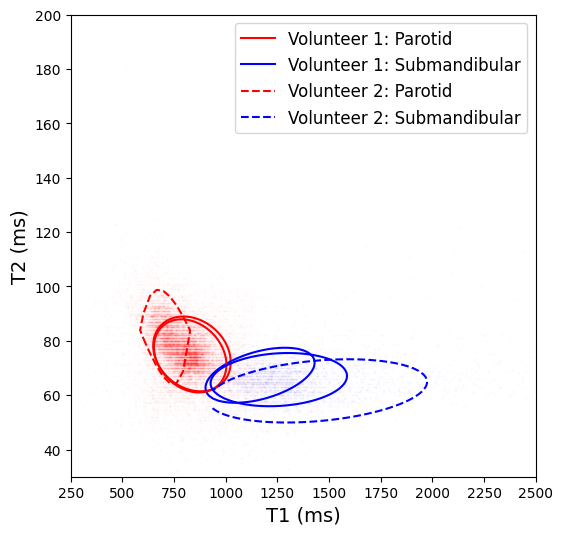

C:\Users\lbmccullum\AppData\Local\Temp\ipykernel_30840\713989332.py:40: RuntimeWarning: invalid value encountered in cast
  temp_points = np.vstack((filtered_x, filtered_y)).T.astype(np.int16)
C:\Users\lbmccullum\AppData\Local\Temp\ipykernel_30840\713989332.py:40: RuntimeWarning: invalid value encountered in cast
  temp_points = np.vstack((filtered_x, filtered_y)).T.astype(np.int16)
C:\Users\lbmccullum\AppData\Local\Temp\ipykernel_30840\713989332.py:40: RuntimeWarning: invalid value encountered in cast
  temp_points = np.vstack((filtered_x, filtered_y)).T.astype(np.int16)
C:\Users\lbmccullum\AppData\Local\Temp\ipykernel_30840\713989332.py:40: RuntimeWarning: invalid value encountered in cast
  temp_points = np.vstack((filtered_x, filtered_y)).T.astype(np.int16)
C:\Users\lbmccullum\AppData\Local\Temp\ipykernel_30840\713989332.py:40: RuntimeWarning: invalid value encountered in cast
  temp_points = np.vstack((filtered_x, filtered_y)).T.astype(np.int16)
C:\Users\lbmccullum\AppData\Local\T

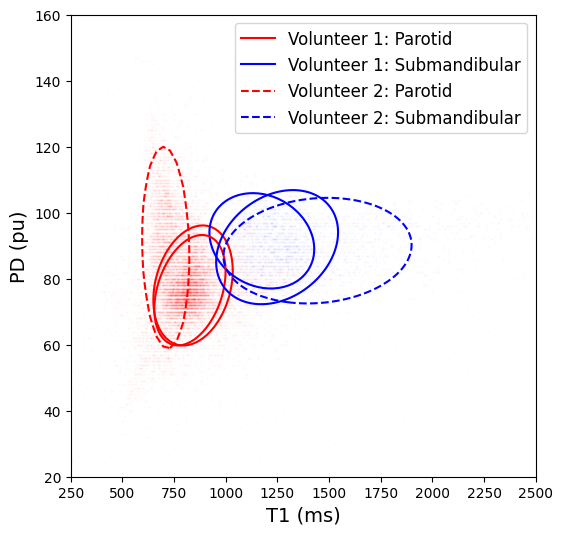

C:\Users\lbmccullum\AppData\Local\Temp\ipykernel_30840\713989332.py:40: RuntimeWarning: invalid value encountered in cast
  temp_points = np.vstack((filtered_x, filtered_y)).T.astype(np.int16)
C:\Users\lbmccullum\AppData\Local\Temp\ipykernel_30840\713989332.py:40: RuntimeWarning: invalid value encountered in cast
  temp_points = np.vstack((filtered_x, filtered_y)).T.astype(np.int16)
C:\Users\lbmccullum\AppData\Local\Temp\ipykernel_30840\713989332.py:40: RuntimeWarning: invalid value encountered in cast
  temp_points = np.vstack((filtered_x, filtered_y)).T.astype(np.int16)
C:\Users\lbmccullum\AppData\Local\Temp\ipykernel_30840\713989332.py:40: RuntimeWarning: invalid value encountered in cast
  temp_points = np.vstack((filtered_x, filtered_y)).T.astype(np.int16)
C:\Users\lbmccullum\AppData\Local\Temp\ipykernel_30840\713989332.py:40: RuntimeWarning: invalid value encountered in cast
  temp_points = np.vstack((filtered_x, filtered_y)).T.astype(np.int16)
C:\Users\lbmccullum\AppData\Local\T

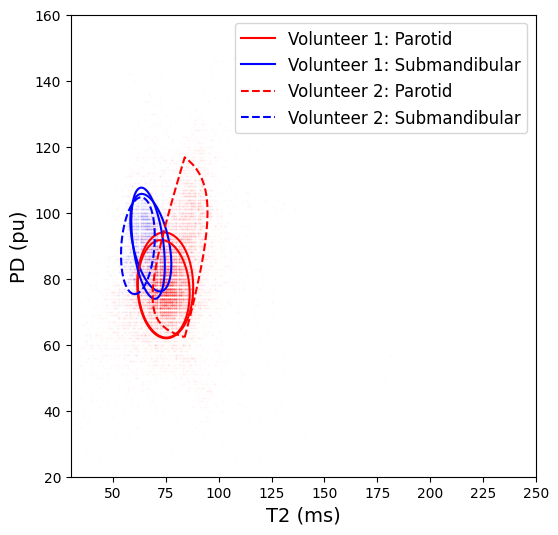

In [7]:
plot_combos = [
    ('T1','T2'),
    ('T1','PD'),
    ('T2','PD')
]
colors = ['r','b']
linestyles = ['-','-','--']
combined_structs = [
    'Parotid',
    'Glnd_Submand'
]
struct_labels = (
    'Parotid',
    'Submandibular',
)
all_sp_labels = {
    1: 'Volunteer 1',
    3: 'Volunteer 2'
}
all_algorithms = {}


for pcc,pc in enumerate(plot_combos):
    all_algorithms[pc] = {}
    plt.figure(figsize=(6,6))
    for cs,sp in enumerate(all_sp.keys()):
        all_algorithms[pc][sp] = {}
        ax = plt.gca()
        for s,temp_struct in enumerate(combined_structs):
            filtered_x = np.concatenate((
                filtered_all_image_data[sp][pc[0]][f'{temp_struct}_L'].flatten(),
                filtered_all_image_data[sp][pc[0]][f'{temp_struct}_R'].flatten()
            ))
            filtered_y = np.concatenate((
                filtered_all_image_data[sp][pc[1]][f'{temp_struct}_L'].flatten(),
                filtered_all_image_data[sp][pc[1]][f'{temp_struct}_R'].flatten()
            ))

            # Doesn't need huge precision, speed it up
            temp_points = np.vstack((filtered_x, filtered_y)).T.astype(np.int16)
            temp_points = temp_points[(temp_points==0).sum(axis=1) < 2]
            all_algorithms[pc][sp][temp_struct] = temp_points
            # Scatter plot
            plt.scatter(temp_points[:,0], temp_points[:,1], alpha=0.01, s=1, c=colors[s])
            if sp in [1,3]:
                plt.plot([], [], linestyle=linestyles[cs], color=colors[s], label=f'{all_sp_labels[sp]}: {struct_labels[s]}')
            # Empirical covariance w/ support_fraction, robust covariance (minimum covariance determinant) if not
            algorithm = EllipticEnvelope(contamination=0.25)
            algorithm.fit(temp_points)
            DecisionBoundaryDisplay.from_estimator(
                algorithm,
                temp_points,
                response_method='decision_function',
                plot_method='contour',
                levels=[0],
                linestyles=linestyles[cs],
                colors=colors[s],
                ax=ax
            )

    plt.xlabel(f'{pc[0]} ({UNIT_TYPES[pc[0]]})', fontsize=14)
    plt.ylabel(f'{pc[1]} ({UNIT_TYPES[pc[1]]})', fontsize=14)
    plt.xlim([MIN_RANGE_CLINICAL[pc[0]], 1.25*MAX_RANGE_CLINICAL[pc[0]]])
    plt.ylim([MIN_RANGE_CLINICAL[pc[1]], MAX_RANGE_CLINICAL[pc[1]]])
    plt.legend(fontsize=12, loc='upper right')
    plt.show()


# Calculate the statistical signficance between clusters

In [8]:
comparisons = [
    ([1,'Parotid'], [2,'Parotid']),
    ([1,'Glnd_Submand'], [2,'Glnd_Submand']),
    ([1,'Parotid'], [3,'Parotid']),
    ([1,'Glnd_Submand'], [3,'Glnd_Submand']),
]

for p,pc in enumerate(plot_combos):
    print(pc)
    for comparison in comparisons:
        temp_data_1 = all_algorithms[pc][comparison[0][0]][comparison[0][1]]
        temp_data_2 = all_algorithms[pc][comparison[1][0]][comparison[1][1]]
        all_cluster_points = np.vstack((temp_data_1, temp_data_2))
        p_value,_ = sigclust.sigclust(
            all_cluster_points,
            mc_iters=1000,
            verbose=False
        )
        print(f'{str(comparison):<50}{p_value_sf(p_value)}')
        print(f'    {plot_combos[p][0]}: {np.mean(temp_data_1[:,0]):.0f} ({np.std(temp_data_1[:,0]):.0f}) vs. {np.mean(temp_data_2[:,0]):.0f} ({np.std(temp_data_2[:,0]):.0f})')
        print(f'    {plot_combos[p][1]}: {np.mean(temp_data_1[:,1]):.0f} ({np.std(temp_data_1[:,1]):.0f}) vs. {np.mean(temp_data_2[:,1]):.0f} ({np.std(temp_data_2[:,1]):.0f})')
    print()


('T1', 'T2')
([1, 'Parotid'], [2, 'Parotid'])                  p = 1.00
    T1: 854 (143) vs. 849 (132)
    T2: 75 (9) vs. 73 (9)
([1, 'Glnd_Submand'], [2, 'Glnd_Submand'])        p = 1.00
    T1: 1212 (252) vs. 1233 (226)
    T2: 69 (9) vs. 66 (6)
([1, 'Parotid'], [3, 'Parotid'])                  p = 1.00
    T1: 854 (143) vs. 736 (175)
    T2: 75 (9) vs. 81 (29)
([1, 'Glnd_Submand'], [3, 'Glnd_Submand'])        p = 0.86
    T1: 1212 (252) vs. 1604 (455)
    T2: 69 (9) vs. 63 (8)

('T1', 'PD')
([1, 'Parotid'], [2, 'Parotid'])                  p = 1.00
    T1: 854 (143) vs. 849 (132)
    PD: 78 (11) vs. 77 (9)
([1, 'Glnd_Submand'], [2, 'Glnd_Submand'])        p = 1.00
    T1: 1212 (252) vs. 1233 (226)
    PD: 91 (8) vs. 90 (9)
([1, 'Parotid'], [3, 'Parotid'])                  p = 1.00
    T1: 854 (143) vs. 736 (175)
    PD: 78 (11) vs. 87 (17)
([1, 'Glnd_Submand'], [3, 'Glnd_Submand'])        p = 1.00
    T1: 1212 (252) vs. 1604 (455)
    PD: 91 (8) vs. 89 (8)

('T2', 'PD')
([1, 'Parot